## <font color='darkblue'>LSTM介紹</font>
([article source](https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b)) 機器學習當中最常利用多層感知器 (<font color='brown'>Multi-Layer Perceptron, MLP</font>) 來訓練模型，如下圖所示:
![1.png](images/1.png)
<br/>
而利用MLP的方式並非能處理所有問題，因為他沒辦法處理時序性的問題，例如：當輸入為 \[1, 2, 3] 希望輸出4 ，而當輸入 \[3, 2, 1] 時希望輸出0 ，對於 MLP 來說，\[1, 2, 3] 和 \[3, 2, 1] 是相同的，因此無法得到預期的結果。

因此有了 <font color='darkblue'>**遞歸神經網絡**</font> (<font color='brown'>Recurrent Neural Network, RNN</font>) 的出現設計如下圖所示。
![2.png](images/2.png)
<br/>
主要概念是將前面輸入得到的權重 (<font color='brown'>Weight</font>) 加入下一層，這樣就可以完成時序性的概念。而 <font color='darkblue'>**長短期記憶**</font> (<font color='brown'>Long Short-Term Memory, LSTM</font>) 是 RNN 的一種，而其不相同之處在於有了更多的控制單元 input gate、output gate、forget gate 示意圖如下:
![3.png](images/3.png)
[瞭解更多：李弘毅 — ML Lecture 21–1: Recurrent Neural Network (Part I)](https://www.youtube.com/watch?v=xCGidAeyS4M)
<br/>

## <font color='darkblue'>Stock Prediction為例</font>
這邊使用資料集 [**SPY dataset: Yahoo SPDR S&P 500 ETF (SPY)**](https://finance.yahoo.com/quote/SPY/history?period1=728236800&period2=1523462400&interval=1d&filter=history&frequency=1d). 目標：利用過去的資料預測未來幾天的 `Adj Close`.

### <font color='darkgreen'>資料建置</font>

In [7]:
#!pip install keras
#!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def readTrain():
    raw_df = pd.read_csv("../../datas/SPY.csv")
    return raw_df

In [11]:
df = readTrain()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.968958,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.153660,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.209057,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.486113,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.596937,531500


In [3]:
df.shape

(6346, 7)

### <font color='darkgreen'>Augment Features</font>
除了基本資料提供的 Features (`Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`) 以外，還可自己增加 Features，例如星期幾、幾月、幾號等等。

In [4]:
def augFeatures(data_df):
    data_df["Date"] = pd.to_datetime(data_df["Date"])
    data_df["year"] = data_df["Date"].dt.year
    data_df["month"] = data_df["Date"].dt.month
    data_df["date"] = data_df["Date"].dt.day
    data_df["day"] = data_df["Date"].dt.dayofweek
    return data_df

df = augFeatures(df)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,date,day
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.968958,1003200,1993,1,29,4
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.153660,480500,1993,2,1,0
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.209057,201300,1993,2,2,1
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.486113,529400,1993,2,3,2
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.596937,531500,1993,2,4,3


### <font color='darkgreen'>Normalization</font>
將所有資料做正規化，而由於 `Date` 是字串非數字，因此先將它 drop 掉:

In [54]:
np.max(X)

Date      2018-04-11
Open      285.929993
High      286.630005
Low       284.500000
Close     286.579987
Volume     871026300
dtype: object

In [55]:
def normalize(data_df):
    data_df = data_df.drop(["Date"], axis=1)
    dmean, dmax, dmin = np.mean(data_df), np.max(data_df), np.min(data_df)
    data_norm_df = data_df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return data_norm_df, dmean, dmax, dmin

y = df[['Adj Close']]
X = df[df.columns[~df.columns.isin(['Adj Close'])]]
X_norm_df, _, _, _ = normalize(X)
X_norm_df.head()

,Open,High,Low,Close,Volume
0,-0.342052,-0.344423,-0.340762,-0.341338,-0.095759
1,-0.342052,-0.343266,-0.339857,-0.340053,-0.096359
2,-0.341021,-0.342752,-0.339210,-0.339668,-0.096680
3,-0.340248,-0.340824,-0.338176,-0.337740,-0.096303
4,-0.337930,-0.339796,-0.337788,-0.336969,-0.096301


### <font color='darkgreen'>Build Training Data</font>
因為我們的資料是有時序性的, 因此在切割 train/split 時會選擇前 80% 作為 training data, 後 20% 作為 testing data:

In [20]:
def train_test_split(X, Y, rate=0.2):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

X_train_df, y_train_df, X_test_df, y_test_df = train_test_split(X_norm_df, y)

In [21]:
X_train_df.shape

(5077, 9)

In [22]:
X_test_df.shape

(1269, 9)

### <font color='darkgreen'>模型建置</font>
![4.png](images/4.png)
<br/>
比較 `many to one` 以及 `many to many`:
![5.png](images/5.png)
<br/>

* <font size='3ptx'>**Many-to-one**</font>

Actually, your code snippet is (almost) an example of this approach:
```python
model = Sequential()
model.add(LSTM(1, input_shape=(timesteps, data_dim)))
```
* <font size='3ptx'>**Many-to-Many**</font>

This is the easiest snippet when the length of the input and output matches the number of recurrent steps:
```python
model = Sequential()
model.add(LSTM(1, input_shape=(timesteps, data_dim), return_sequences=True))
```
更多有關於 LSTM 的模型種類說明, 可以參考這篇在 Stackoverlfow 的發問 "[**Many to one and many to many LSTM examples in Keras**](https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras)".



更多有關於 Keras LSTM Layer, 請參考 [API 文件](https://keras.io/api/layers/recurrent_layers/lstm/), 底下只列出使用到的參數:
* **units:** Positive integer, dimensionality of the output space.
* **input_length**: Number of sequence you want to train
* **input_dim**: The feature dimension of one point in the sequence.
* **return_sequences**: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: `False`.

## <font color='darkgreen'>一對一模型</font>

In [88]:
def buildOneToOneModel(shape, units=9):
    model = Sequential()
    model.add(LSTM(units, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    # output shape: (1, 1)
    model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

將過去的天數 `pastDay` 設為1，預測的天數 `futureDay` 也設為1

In [36]:
def buildTrain(train, past_day=30, future_day=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-future_day-past_day):
        X_train.append(np.array(train.iloc[i:i+past_day]))
        Y_train.append(np.array(train.iloc[i+past_day:i+past_day+future_day]["Adj Close"]))
        
    print(f"past_day={past_day}; future_day={future_day}")
    X_train, Y_train = np.array(X_train), np.array(Y_train) 
    print(f"X_train.shape={X_train.shape}; Y_train.shape={Y_train.shape}")
    return np.array(X_train), np.array(Y_train)

In [92]:
train = readTrain()
train_Aug = augFeatures(train)
train_norm, dmean, dmax, dmin = normalize(train_Aug)
# Change past_day, future_day
X_train, Y_train = buildTrain(train_norm, past_day=1, future_day=1)
X_train, Y_train, X_val, Y_val = train_test_split(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]

past_day=1; future_day=1
X_train.shape=(6344, 1, 10); Y_train.shape=(6344, 1)


In [57]:
X_train.shape

(5710, 1, 10)

In [33]:
X_train[:2]

array([[[-0.29432396, -0.29512489, -0.29233917, -0.29205506,
         -0.26349695, -0.09554067, -0.40678853,  0.1352176 ,
         -0.42394684,  0.24491806]],

       [[-0.29232725, -0.2946107 , -0.29039968, -0.29179804,
         -0.26333671, -0.09663491, -0.40678853,  0.1352176 ,
         -0.39061351,  0.49491806]]])

In [67]:
model = buildOneToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 9)              720       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 1)              10        
Total params: 730
Trainable params: 730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
45/45 [==============================] - 2s 8ms/step - loss: 0.0480 - val_loss: 0.0658
Epoch 2/1000
45/45 [==============================] - 0s 1ms/step - loss: 0.0238 - val_loss: 0.0279
Epoch 3/1000
45/45 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 4/1000
45/45 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 5/1000
45/45 [==============================] - 0s 1ms/step - loss: 3.0905e-04 - val_loss: 0.0013
Epoch 6/1000
4

45/45 [==============================] - 0s 1ms/step - loss: 4.3913e-05 - val_loss: 2.5996e-04
Epoch 72/1000
45/45 [==============================] - 0s 1ms/step - loss: 4.2270e-05 - val_loss: 2.5121e-04
Epoch 73/1000
45/45 [==============================] - 0s 1ms/step - loss: 4.0751e-05 - val_loss: 2.5096e-04
Epoch 74/1000
45/45 [==============================] - 0s 1ms/step - loss: 4.1625e-05 - val_loss: 2.7283e-04
Epoch 75/1000
45/45 [==============================] - 0s 1ms/step - loss: 4.0329e-05 - val_loss: 2.6246e-04
Epoch 76/1000
45/45 [==============================] - 0s 1ms/step - loss: 3.9975e-05 - val_loss: 2.4159e-04
Epoch 77/1000
45/45 [==============================] - 0s 1ms/step - loss: 4.0061e-05 - val_loss: 2.6205e-04
Epoch 78/1000
45/45 [==============================] - 0s 1ms/step - loss: 4.0308e-05 - val_loss: 2.4051e-04
Epoch 79/1000
45/45 [==============================] - 0s 1ms/step - loss: 4.1312e-05 - val_loss: 2.7457e-04
Epoch 80/1000
45/45 [============

Epoch 146/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.6670e-05 - val_loss: 6.7310e-05
Epoch 147/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.7698e-05 - val_loss: 5.8225e-05
Epoch 148/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.6707e-05 - val_loss: 5.1292e-05
Epoch 149/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.8385e-05 - val_loss: 5.4460e-05
Epoch 150/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.7630e-05 - val_loss: 7.2561e-05
Epoch 151/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.8140e-05 - val_loss: 5.5896e-05
Epoch 152/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.9290e-05 - val_loss: 6.1939e-05
Epoch 153/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.8650e-05 - val_loss: 4.9757e-05
Epoch 154/1000
45/45 [==============================] - 0s 1ms/step - loss: 2.7237e-05 - val_loss: 5.7250e-05
Epoch 155/

Let's draw the real `Adj Close` and predicted `Adj Close`:

In [68]:
y_pred = model.predict(X_train)

In [69]:
y_pred = y_pred.reshape((y_pred.shape[0], 1))
y_real = Y_train.reshape((Y_train.shape[0], 1))
y_pred.shape

(5710, 1)

In [70]:
ymean, ymax, ymin = dmean['Adj Close'], dmax['Adj Close'], dmin['Adj Close']
y_pred_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, y_pred))
y_real_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, y_real))

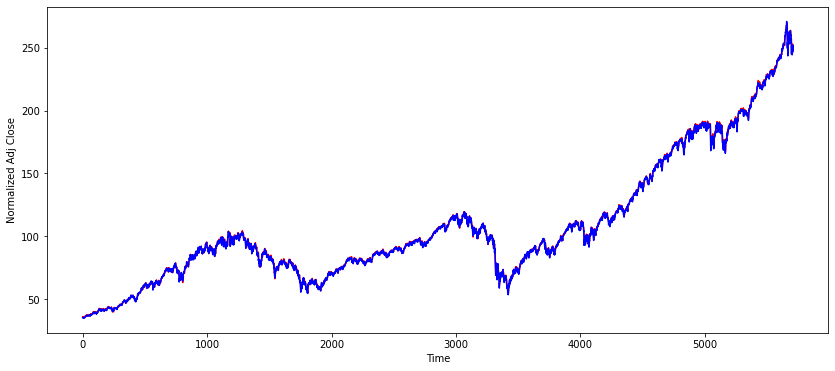

In [71]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=14,6

x_axis = list(range(len(y_pred)))
plt.plot(x_axis, y_pred_denorm, color='r')
plt.plot(x_axis, y_real_denorm, color='b')
plt.xlabel('Time')
plt.ylabel('Normalized Adj Close')
plt.show()

在訓練資料看起來相當好, 來看一下在測試資料上面的表現:

In [73]:
y_test = model.predict(X_val)

In [75]:
y_test = y_test.reshape((y_test.shape[0], 1))
y_val = Y_val.reshape((Y_val.shape[0], 1))
y_test.shape

(634, 1)

In [76]:
y_test_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, y_test))
y_val_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, y_val))

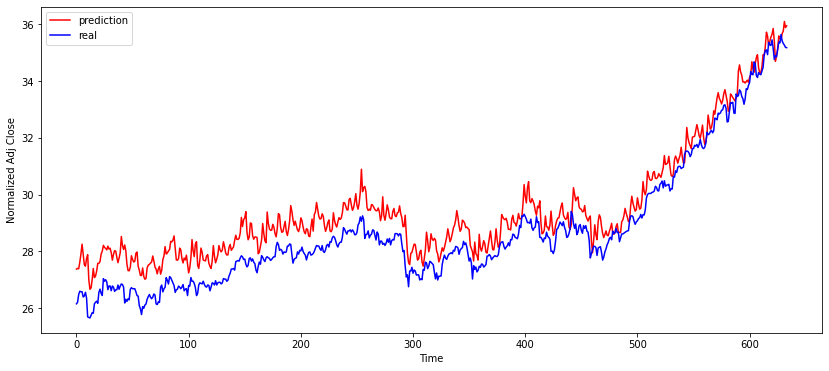

In [79]:
x_axis = list(range(len(y_test_denorm)))
plt.plot(x_axis, y_test_denorm, color='r', label='prediction')
plt.plot(x_axis, y_val_denorm, color='b', label='real')
plt.xlabel('Time')
plt.ylabel('Normalized Adj Close')
plt.legend()
plt.show()

### <font color='darkgreen'>多對一模型</font>
LSTM 參數 <font color='blue'>return_sequences=False</font> ，未設定時 default 也為 False，而且不可使用 TimeDistribution

In [89]:
def buildManyToOneModel(shape, units=10):
    model = Sequential()
    model.add(LSTM(units, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

需要設定的有 <font color='blue'>past_day=30</font>、<font color='blue'>future_day=1</font> ，且注意 `Y_train` 的維度需為二維

In [104]:
train = readTrain()
train_Aug = augFeatures(train)
train_norm, dmean, dmax, dmin = normalize(train_Aug)
# Change past_day, future_day
X_train, Y_train = buildTrain(train_norm, past_day=30, future_day=1)

# Because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = train_test_split(X_train, Y_train, 0.1)

past_day=30; future_day=1
X_train.shape=(6315, 30, 10); Y_train.shape=(6315, 1)


In [97]:
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/1000
45/45 [==============================] - 2s 19ms/step - loss: 0.0262 - val_loss: 0.0019
Epoch 2/1000
45/45 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 3/1000
45/45 [==============================] - 0s 5ms/step - loss: 6.2054e-04 - val_loss: 0.0015
Epoch 4/1000
45/45 [==============================] - 0s 6ms/step - loss: 3.5541e-04 - val_loss: 0.0011
Epoch 5/1000
45/45 [==============================] - 0s 6ms/step - loss: 2.6018e-04 - val_loss: 8.0352e-04
Epoch 6/1000
45/45 [==============================] - 0s 6ms/step - loss: 2.0734e-04 - val_loss: 7.1352e-04
Epoch 7/1000
45/45 [==============================] - 0s 6ms/step - loss: 1.7490e-04 - val_loss: 5.7760e-04
Epoch 8/1000
45/45 [==============================] - 0s 5ms/step - loss: 1.6083e-04 - val_loss: 4.5405e-04
Epoch 9/1000
45/45 [==============================] - 0s 6ms/step - loss: 1.3395e-04 - val_loss: 3.6483e-04
Epoch 10/1000
45/45 [==============================

45/45 [==============================] - 0s 8ms/step - loss: 4.2681e-05 - val_loss: 2.3346e-05
Epoch 77/1000
45/45 [==============================] - 0s 7ms/step - loss: 3.9792e-05 - val_loss: 1.2081e-05
Epoch 78/1000
45/45 [==============================] - 0s 7ms/step - loss: 4.2017e-05 - val_loss: 2.1448e-05
Epoch 79/1000
45/45 [==============================] - 0s 8ms/step - loss: 4.0800e-05 - val_loss: 1.0754e-05
Epoch 80/1000
45/45 [==============================] - 0s 8ms/step - loss: 4.0887e-05 - val_loss: 1.0309e-05
Epoch 81/1000
45/45 [==============================] - 0s 7ms/step - loss: 4.0217e-05 - val_loss: 1.6947e-05
Epoch 82/1000
45/45 [==============================] - 0s 8ms/step - loss: 4.0632e-05 - val_loss: 2.6344e-05
Epoch 83/1000
45/45 [==============================] - 0s 8ms/step - loss: 3.9816e-05 - val_loss: 1.7275e-05
Epoch 84/1000
45/45 [==============================] - 0s 8ms/step - loss: 4.4249e-05 - val_loss: 8.1780e-06
Epoch 85/1000
45/45 [============

In [103]:
y_pred = model.predict(X_train)

In [105]:
Y_train.shape

(5684, 1)

來看一下模型在訓練資料上的表現:

In [106]:
ymean, ymax, ymin = dmean['Adj Close'], dmax['Adj Close'], dmin['Adj Close']
y_pred_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, y_pred))
y_real_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, Y_train))

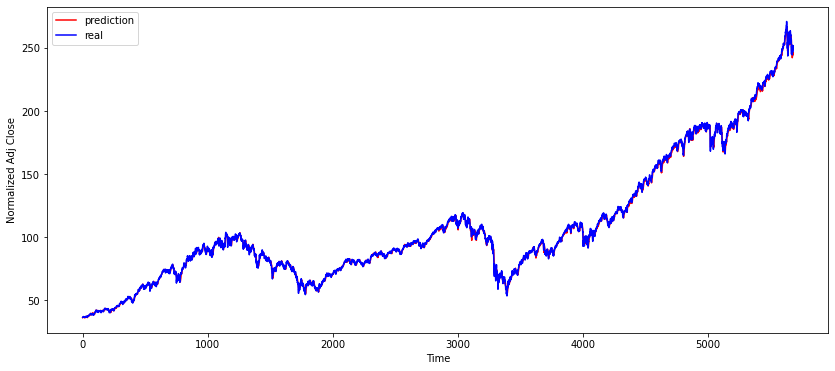

In [107]:
x_axis = list(range(len(y_pred_denorm)))
plt.plot(x_axis, y_pred_denorm, color='r', label='prediction')
plt.plot(x_axis, y_real_denorm, color='b', label='real')
plt.xlabel('Time')
plt.ylabel('Normalized Adj Close')
plt.legend()
plt.show()

接著來看測試資料上的結果:

In [108]:
y_pred = model.predict(X_val)

In [109]:
y_pred_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, y_pred))
y_real_denorm = list(map(lambda e: e * (ymax-ymin) + ymean, Y_val))

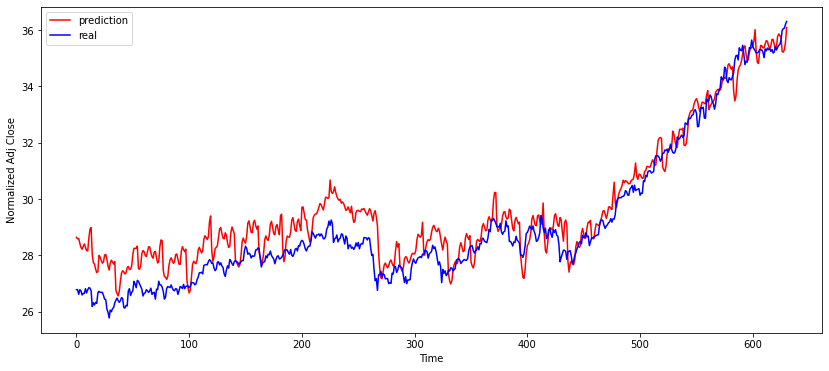

In [110]:
x_axis = list(range(len(y_pred_denorm)))
plt.plot(x_axis, y_pred_denorm, color='r', label='prediction')
plt.plot(x_axis, y_real_denorm, color='b', label='real')
plt.xlabel('Time')
plt.ylabel('Normalized Adj Close')
plt.legend()
plt.show()

## <font color='darkblue'>Supplement</font>
* [ML Lecture 21-1: Recurrent Neural Network (Part I)](https://www.youtube.com/watch?v=xCGidAeyS4M)
* [Keras 關於 LSTM 的 units 參數，還是不理解?](https://www.zhihu.com/question/64470274)
* [Stackoverflow - Many to one and many to many LSTM examples in Keras](https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras)